<a href="https://colab.research.google.com/github/Hase-U/learn_pytorch_advanced/blob/master/mycode/1_image_classification/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像処理と移転学習
commit用
```
mycode/1_image_classification/
```


## 1-1 学習済みのVGGモデルを使用する方法


In [0]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import time
from google.colab import files

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [0]:
print("PyTorch V: ",torch.__version__)
print("Torchvision V: ",torchvision.__version__)

PyTorch V:  1.4.0
Torchvision V:  0.5.0


In [0]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.eval()
net

### 前処理
今回用いるモデル(VGGモデル)がどのような環境を前提として学習されたものかに合わせて前処理する必要がある。

In [0]:
class BaseTransform():

  def __init__(self, resize, mean, std):
    self.base_transform = transforms.Compose([transforms.Resize(resize),
                                             transforms.CenterCrop(resize),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std)
                                             ])
    
  def __call__(self, img):
    return self.base_transform(img)

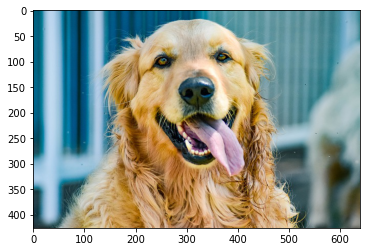

<class 'torch.Tensor'> torch.Size([3, 224, 224])
<class 'numpy.ndarray'> (224, 224, 3)


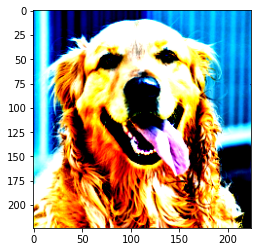

In [0]:
#動作確認
img = Image.open('goldenretriever-3724972_640.jpg')

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize,mean,std)
img_trans = transform(img)

# このままでは出力できない。テンソルからNumPyに戻して順番を変える必要がある
# plt.imshow(img_trans)
print(type(img_trans),img_trans.size())

img_trans = img_trans.numpy().transpose((1,2,0))
print(type(img_trans),img_trans.shape)
img_trans = np.clip(img_trans,0,1) #要素の最大最小の範囲を決める
plt.imshow(img_trans)
plt.show()

### 後処理
そのままではテンソル型になっているのでNUmPy型に変換する。
- ```detach()```を用いてネットワークから切り離す
- ```.numpy()```を用いてNumPy型に変換

あとはNumPyとして処理

(注意)
ここで用いている```./imagenet_class_index.json```は別でダウンロードする必要があった。

In [0]:
ILSVRC_class_index = json.load(open("./imagenet_class_index.json","r"))
ILSVRC_class_index

In [0]:
class ILSVRCPredictor():

  def __init__(self, class_index):
    self.class_index = class_index

  def predict_max(self, out):
    maxid = np.argmax(out.detach().numpy())
    predicted_label_name = self.class_index[str(maxid)][1]

    return predicted_label_name

### 学習済みVGGモデルで手元の画像を予測


In [0]:
#後処理
ILSVRC_class_index = json.load(open("./imagenet_class_index.json","r"))
predictor = ILSVRCPredictor(ILSVRC_class_index)

#入力データの読み込み
img = Image.open('goldenretriever-3724972_640.jpg')

#前処理
transform = BaseTransform(resize,mean,std)
img_trans = transform(img)
inputs = img_trans.unsqueeze_(0) #バッチサイズの情報まで持たせた

out = net(inputs)
result = predictor.predict_max(out)

print(result)

golden_retriever


## 1-2 PyTorchによるディープラーニング実装の流れ

## 1-3 転移学習の実装
データの用意
```
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip
```
ローカルからcolaboratoryにアップロードも可能だが、結構重い

In [0]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

### Datasetの作成
- 前処理
  - データオーギュメンテーション
- データのファイルパスを格納したリスト型変数を作成
- ```torch.utils.data```を継承してDatasetを作成

**データオーギュメンテーション：**入力データをちょっといじって汎化性能を上げる

In [0]:
class ImageTransform():

  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train': transforms.Compose([transforms.RandomResizedCrop(resize,scale=(0.5,1.0)), #データオーギュメンテーション
                                     transforms.RandomHorizontalFlip(), #データオーギュメンテーション
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)
                                     ]),
        'val': transforms.Compose([
                                   transforms.Resize(resize),
                                   transforms.CenterCrop(resize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)
                                  
        ])
    }

  def __call__(self, img, phase = 'train'):
    return self.data_transform[phase](img)

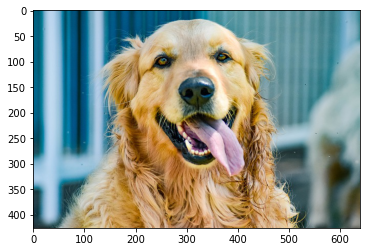

<class 'numpy.ndarray'> (224, 224, 3)


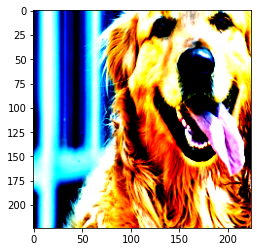

In [4]:
# 前処理の動作確認
img = Image.open('goldenretriever-3724972_640.jpg')

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(resize,mean,std)
img_trans = transform(img,'train')

img_trans = img_trans.numpy().transpose((1,2,0))
print(type(img_trans),img_trans.shape)
img_trans = np.clip(img_trans,0,1) #要素の最大最小の範囲を決める
plt.imshow(img_trans)
plt.show()

In [0]:

def make_datapath_list(phase="train"):

  rootpath = "./hymenoptera_data/"
  target_path = osp.join(rootpath+phase+"/**/*.jpg")
  print(target_path)

  path_list = []

  for path in glob.glob(target_path):
    path_list.append(path)

  return path_list

train_list = make_datapath_list("train")
val_list = make_datapath_list("val")

print(train_list)

In [0]:
class HymenopteraDataset(data.Dataset):

  def __init__(self, file_list, transform=None, phase='train'):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list) #画像の枚数を返す

  def __getitem__(self, index): #前処理をした画像のTensor形式のデータとラベルを取得

    #index番目の画像をロード
    img_path = self.file_list[index]
    img = Image.open(img_path)

    img_transformed = self.transform(img, self.phase) #上で自作したImageTransform()

    if self.phase == "train":
      label = img_path[25:29]  #原本とはパスが異なるので注意が必要
    elif self.phase == "val":
      label = img_path[23:27]


    if label == "ants":
      label = 0
    elif label == "bees":
      label = 1

    return img_transformed, label

In [8]:
# 実行

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_dataset = HymenopteraDataset(train_list,ImageTransform(size,mean, std),'train')
val_dataset = HymenopteraDataset(val_list,ImageTransform(size,mean, std),'val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


### DataLoderの制作
DataLoaderはPyTorchのtorch.utils.data.DataLoaderクラスを転用する。

In [0]:
batch_size = 32

# DataLoaderの作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}

In [10]:
#動作確認
batch_iterator = iter(dataloaders_dict["train"])

inputs , labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1])


### ネットワークモデルの作成
今回は学習済みモデルの最後の層を付け替える

In [11]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
print(net)
print("本来このnetの全結合層の最後が4096入力の1000出力だが、ここを2出力に付け替える")

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 損失関数の定義

In [0]:
criterion = nn.CrossEntropyLoss()

### 最適化手法を設定
パラメータを更新するものは```requires_grad```を```True```に、それ以外のものは```False```に設定しておく。
更新するパラメータのみを```optimizer```に渡す。

今回はVGG16の最後の層のみを新たにつけたのでそこだけを学習させている。


In [22]:
#転移学習で学習させるパラメータのみ格納して更新させる
params_to_update = []

##以下のコードでどのようなパラメータが含まれるか確認できるので更新したいものだけ格納する
# for name, _ in net.named_parameters():
#   print(name)
update_param_names = ["classifier.6.weight","classifier.6.bias"]

#学習させるパラメータ以外のbackwardをオフに設定する。
for name, param in net.named_parameters():
  if name in update_param_names:
    param.requires_grad = True
    params_to_update.append(param)
    print(name)

  else:
    param.requires_grad = False

#params_to_updateの確認
print("----------------------")
print(params_to_update)

#最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr = 0.001, momentum = 0.9)

classifier.6.weight
classifier.6.bias
----------------------
[Parameter containing:
tensor([[ 0.0117,  0.0116,  0.0082,  ..., -0.0072,  0.0059, -0.0065],
        [-0.0071, -0.0131, -0.0117,  ..., -0.0079, -0.0070,  0.0085]],
       requires_grad=True), Parameter containing:
tensor([-0.0087,  0.0008], requires_grad=True)]


### 学習・検証の実施

**気になったこと**
- ```with torch.set_grad_enabled(phase == "train"):```の必要性：これはおそらくoptimizerの中で```requires_grad```をTrueにしているもののについての```grad```をいじってるものだと思われ

- ```epoch_loss += loss.item() * inputs.size(0)```：わざわざ```loss.item()```にインプットサイズをかけているのは```loss.item()```が平均値を返すので標本数をかけておかないとあとで全体の値を出す時に困る(バッチサイズが異なるものがあった時に計算が合わない)

In [0]:
#モデルを学習させる関数

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

  t_start = time.time()

  #epochのループ
  for epoch in range(num_epochs):
    print("Epoch {}/{} done".format(epoch+1, num_epochs))
    print("------------------------")

    #epochごとの学習と検証ループ
    for phase in ["train", "val"]:
      if phase == "train":
        net.train()
      else:
        net.eval()


      epoch_loss = 0.0
      epoch_corrects = 0

      #学習してない(ランダムなネットワーク)状態でのvalを取り出す
      if (epoch==0) and (phase == "train"):
        continue

      #データロードからミニバッチを取り出すループ
      #tqdmを使うと進捗状況を表示してくれる
      # for inputs, labels in tqdm(dataloaders_dict[phase], total=len(dataloaders_dict[phase])):
      for inputs, labels in tqdm(dataloaders_dict[phase]):

        #optimizerの初期化
        optimizer.zero_grad()

        #順伝搬の計算
        #optimizerの中でTrueとなっているパラメータの更新を"train"の時は可能にする。
        #optimizerの中でFlaseとなっているものは常に更新されない
        with torch.set_grad_enabled(phase == "train"):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs,1) #あとで予測の精度の計算に用いる,lossがあるしいらないのでは？

          #訓練時はbackward
          if phase == "train":
            loss.backward()
            optimizer.step()

          #イテレーション結果の計算
          epoch_loss += loss.item() * inputs.size(0)
          #正解数の合計
          epoch_corrects += torch.sum(preds == labels.data)

      #epochごとのlossと精度を出す
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)

      t = time.time()
      print("{} Loss: {:.4f},  Acc:{:.4f}, time:{}".format(phase, epoch_loss, epoch_acc, t- t_start), flush=True)


In [55]:
#動作の確認
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2 done
------------------------



100%|██████████| 5/5 [01:05<00:00, 13.00s/it]

val Loss: 0.1108,  Acc:0.9608, time:65.0249445438385




  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/2 done
------------------------



100%|██████████| 8/8 [01:43<00:00, 12.92s/it]

train Loss: 0.0868,  Acc:0.9630, time:168.39740324020386




100%|██████████| 5/5 [01:06<00:00, 13.21s/it]

val Loss: 0.1005,  Acc:0.9542, time:234.4403202533722


## 1-5ファインチューニング
**転移学習**：元からあるモデルに自分で付け加えた部分だけを学習する

**ファインチューニング(fine tuning)**：元からあるモデルのパラメータについても学習する。ただし入力層に近い部分の学習率は小さく、出力層の学習率を大きくすることが一般的

計算が多いのでGPUを用いる。

In [0]:
#上にも同じコードがある
#データのディレクトリが異なると正しく作動しないので使わない
# from dataloader_image_classification import ImageTransform,make_datapath_list,HymenopteraDataset

- Dataset,DataLoader
- ネットワークモデル
- 損失関数
- 最適化手法
- 学習・検証の実施

### Dataset,DataLoaderの作成

In [81]:
#antsとbeesの画像へのファイルパスのリストを作成する
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

#Datasetの作成
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
train_dataset = HymenopteraDataset(
    file_list=train_list, 
    transform=ImageTransform(size,mean,std),
    phase="train")

val_dataset = HymenopteraDataset(
    file_list=val_list, 
    transform=ImageTransform(size,mean,std),
    phase="val")

./hymenoptera_data/train/**/*.jpg
./hymenoptera_data/val/**/*.jpg


In [0]:
#DataLoaderの作成
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle = False)

dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}

### ネットワーク構築


In [0]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

### 損失関数


In [0]:
criterion = nn.CrossEntropyLoss()

### 最適化手法の設定
学習率を層によって変えたいので、学習率の数だけリストを作成する

In [90]:
for name,_ in net.named_parameters():
  print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [0]:
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

#学習させる層のパラメータを指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight","classifier.0.bias","classifier.3.weight","classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight","classifier.6.bias"]

#パラメータごとに各リストに格納する
for name, param in net.named_parameters():
  if update_param_names_1[0] in name: #なるほど!
    param.requires_grad = True
    params_to_update_1.append(param)
    
  elif name in update_param_names_2:
    param.requires_grad = True
    params_to_update_2.append(param)

  elif name in update_param_names_3:
    param.requires_grad = True
    params_to_update_3.append(param)

  else:
    param.requires_grad = False

In [0]:
#最適化手法の設定
optimizer = optim.SGD([
                       {"params":params_to_update_1,"lr":1e-4},
                       {"params":params_to_update_2,"lr":5e-4}, #なるほど!
                       {"params":params_to_update_3,"lr":1e-3}
], momentum = 0.9)

# 学習・検証の実施
PyTorchではニューラルネットワークの順伝搬と誤差関数の計算手法がある程度一定であれば

```torch.backends.cudnn.bencmark = True```
で高速化できるらしい

In [0]:
#モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer,num_epochs):

  t_start = time.time()

  #初期設定
  #GPUの有無を確認
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("使用デバイス : ", device)

  #ネットワークをGPUへ転送
  net.to(device)

  #高速化
  torch.backends.cudnn.bencmark = True

  """
  ------------------------------------------------------------------

  以下はGPUにデータを転送する以外は前に作った部分と同じ

  ------------------------------------------------------------------

  """

  #epochのループ
  for epoch in range(num_epochs):
    print("Epoch {}/{} done".format(epoch+1, num_epochs))
    print("------------------------")

    #epochごとの学習と検証ループ
    for phase in ["train", "val"]:
      if phase == "train":
        net.train()
      else:
        net.eval()


      epoch_loss = 0.0
      epoch_corrects = 0

      #学習してない(ランダムなネットワーク)状態でのvalを取り出す
      if (epoch==0) and (phase == "train"):
        continue

      #データロードからミニバッチを取り出すループ
      #tqdmを使うと進捗状況を表示してくれる
      # for inputs, labels in tqdm(dataloaders_dict[phase], total=len(dataloaders_dict[phase])):
      for inputs, labels in tqdm(dataloaders_dict[phase]):

        """
        ------------------------------
        この部分だけ追加されている
        ------------------------------
        """
        inputs = inputs.to(device)
        labels = labels.to(device)


        #optimizerの初期化
        optimizer.zero_grad()

        #順伝搬の計算
        #optimizerの中でTrueとなっているパラメータの更新を"train"の時は可能にする。
        #optimizerの中でFlaseとなっているものは常に更新されない
        with torch.set_grad_enabled(phase == "train"):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs,1) #あとで予測の精度の計算に用いる,lossがあるしいらないのでは？

          #訓練時はbackward
          if phase == "train":
            loss.backward()
            optimizer.step()

          #イテレーション結果の計算
          epoch_loss += loss.item() * inputs.size(0)
          #正解数の合計
          epoch_corrects += torch.sum(preds == labels.data)

      #epochごとのlossと精度を出す
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)

      t = time.time()
      print("{} Loss: {:.4f},  Acc:{:.4f}, time:{}".format(phase, epoch_loss, epoch_acc, t- t_start), flush=True)

In [103]:
#実行
num_epochs = 2
train_model(net,dataloaders_dict, criterion, optimizer, num_epochs)


  0%|          | 0/5 [00:00<?, ?it/s]

使用デバイス :  cuda:0
Epoch 1/2 done
------------------------



100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

val Loss: 0.8255,  Acc:0.3399, time:1.693279504776001




  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/2 done
------------------------



100%|██████████| 8/8 [00:03<00:00,  2.17it/s]

train Loss: 0.5298,  Acc:0.7366, time:5.394259214401245




100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

val Loss: 0.1743,  Acc:0.9412, time:7.065384864807129


## 学習したネットワークの保存・ロード
ローカルにダウンロードするのにめちゃくちゃ時間がかかるのが気になる

In [0]:
torch.save(net.state_dict(), "./netPara")

In [105]:
!ls

dataloader_image_classification.py  hymenoptera_data.zip  sample_data
goldenretriever-3724972_640.jpg     netPara
hymenoptera_data		    __pycache__


In [106]:
use_pretrained = True
net_load = models.vgg16(pretrained=use_pretrained)
net_load.classifier[6] = nn.Linear(in_features=4096, out_features=2)
net_load.train()

net_load.load_state_dict(torch.load("./netPara"))

<All keys matched successfully>

In [0]:
files.download('./netPara')